<a href="https://colab.research.google.com/github/ErlantzCalvo/Parkinson_Detection/blob/erlantz/Parkinson_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd drive/My\ Drive
%cd 'Colab Notebooks/'
%cd 'datasets/ParkinsonDisease/'

/content/drive/My Drive
/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/datasets/ParkinsonDisease


In [43]:
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


# Data explanation
The data .csv has the next format: \\
  X ; Y; Z; Pressure; GripAngle; Timestamp; Test ID

----------------
Test ID: \\
0: Static Spiral Test ( Draw on the given spiral pattern) \\
1: Dynamic Spiral Test ( Spiral pattern will blink in a certain time, so subjects need to continue on their draw) \\
2: Circular Motion Test (Subjectd draw circles around the red point)

# Sources and explanation
Isenkul, Muhammed & Sakar, Betul & Kursun, O.. (2014). Improved Spiral Test Using Digitized Graphics Tablet for Monitoring Parkinson’s Disease. 10.13140/RG.2.1.1898.6005. 

Sakar, Betul & Isenkul, Muhammed & Sakar, C. Okan & Sertbaş, Ahmet & Gurgen, F. & Delil, Sakir & Apaydin, Hulya & Kursun, Olcay. (2013). Collection and Analysis of a Parkinson Speech Dataset With Multiple Types of Sound Recordings. Biomedical and Health Informatics, IEEE Journal of. 17. 828-834. 10.1109/JBHI.2013.2245674. 

# Dataset
https://archive.ics.uci.edu/ml/datasets/Parkinson+Disease+Spiral+Drawings+Using+Digitized+Graphics+Tablet


# Loading data
We've got 2 different datasets:
  

*   **Control**: People who did the tests without having the Parkinson disease. 
*   **Parkinson**: People who did the tests having the Parkinson disease. 

*Note:* The parkinson dataset is splitted in two different paths, so we'll load both of them and then mix them.

In [27]:
CONTROL_DATASET_PATH = 'hw_dataset/control'
PARKINSON_DATASET_PATH = 'hw_dataset/parkinson'
PARKINSON_DATASET_PATH_2 = 'new_dataset/parkinson'


def loadDatasets(control_path, parkinson_path):
  COLUMN_NAMES = ['X', 'Y', 'Z', 'Pressure', 'GripAngle', 'Timestamp', 'Test ID','UserId']
  userid = 0
  #Load Control dataset
  control_files = os.listdir(control_path)
  df_control = pd.DataFrame(columns=COLUMN_NAMES)
  #df_control.columns = COLUMN_NAMES
  for i in tqdm(range(len(control_files)), desc= 'Control files: ', unit=' files'):
    new_user_path = os.path.join(control_path, control_files[i])
    new_user = pd.read_csv(new_user_path, header=None,  sep=';', names=COLUMN_NAMES)
    new_user['UserId'] = userid
    df_control = df_control.append(new_user)
    userid +=1

  


  #Load parkinson dataset
  parkinson_files = os.listdir(parkinson_path)
  df_parkinson = pd.DataFrame(columns=COLUMN_NAMES)

  for j in tqdm(range(len(parkinson_files)), desc= 'Parkinson files: ', unit=' files'):
    new_user_path = os.path.join(parkinson_path, parkinson_files[j])  
    new_user = pd.read_csv(new_user_path, header=None,  sep=';',names=COLUMN_NAMES)
    new_user['UserId'] = userid
    df_parkinson = df_parkinson.append(new_user)
    userid +=1

  '''parkinson_files =  os.listdir(PARKINSON_DATASET_PATH_2)
  for k in tqdm(range(len(parkinson_files)), desc= 'Parkinson files: ', unit=' files'):
    new_user_path = os.path.join(PARKINSON_DATASET_PATH_2, parkinson_files[i])  
    new_user = pd.read_csv(new_user_path, header=None,  sep=';')
    new_user['UserId'] = userid
    df_parkinson = df_parkinson.append(new_user)
    userid +=1'''


  #df_parkinson.columns = COLUMN_NAMES
  return df_parkinson, df_control
df_parkinson, df_control= loadDatasets(CONTROL_DATASET_PATH, PARKINSON_DATASET_PATH)


Parkinson files: 100%|██████████| 25/25 [00:00<00:00, 52.63 files/s]


In [ ]:

for k in range(3):
  j=15
  print(f'Test nº {k}\n\n')
  for i in range(15):
    pd_angle = df_parkinson[(df_parkinson['UserId'] ==j) & (df_parkinson['Test ID']==k)]
    c_angle = df_control[(df_control['UserId'] ==i) & (df_control['Test ID']==k)]

    if len(pd_angle)<1 or len(c_angle)<1:
      j+=1
      continue
    pd_start_time = pd_angle['Timestamp'].iloc[0]
    pd_end_time = pd_angle['Timestamp'].iloc[-1]
    duration = pd_end_time - pd_start_time
    print(f'Parkinson  -->   Variance: {pd_angle["GripAngle"].var()}   Standard deviation: {pd_angle["GripAngle"].std()}    Time: {duration} ms')

    
    pd_start_time = c_angle['Timestamp'].iloc[0]
    pd_end_time = c_angle['Timestamp'].iloc[-1]
    duration = pd_end_time - pd_start_time
    print(f'Control    -->   Variance: {c_angle["GripAngle"].var()}   Standard deviation: { c_angle["GripAngle"].std()}     Time: {duration} ms')
    print('-'*10)
    j+=1

We prepare the final dataset with the model will be trained and tested. So we will do some feature extraction and join the control dataset and the parkinson dataset.





In [41]:
def extractFeatures(dataset, subjects, isParkinson):
  NEW_COLUMNS = ['UserID', 'GripAngleVariance', 'GripAngleStd', 'PressureVariance', 'PressureStd', 'Duration', 'Test ID', 'Parkinson']
  df_polished = pd.DataFrame(columns=NEW_COLUMNS)

  for i in range(3):
    for j in range(len(subjects)):
      df_subject = dataset[(dataset['Test ID'] ==i) & (dataset['UserId']==subjects[j])]
      
      if len(df_subject)>0:
        #insert new values to the dataset
        angleVariance = df_subject['GripAngle'].var()
        angleStDeviation = df_subject['GripAngle'].std()

        pressureVariance =  df_subject['Pressure'].var()
        pressureStDeviation = df_subject['Pressure'].std()

        startTime = df_subject['Timestamp'].iloc[0]
        endTime = df_subject['Timestamp'].iloc[-1]
        duration = endTime - startTime

        df_polished = df_polished.append({'UserID': int(subjects[j]), 'GripAngleVariance' : angleVariance, 'GripAngleStd' : angleStDeviation, 'PressureVariance' : pressureVariance, 'PressureStd' : pressureStDeviation, 'Duration' : duration, 'Test ID' : i, 'Parkinson' : isParkinson},ignore_index = True)
        df_polished[['UserID', 'Duration', 'Test ID', 'Parkinson']] =  df_polished[['UserID', 'Duration', 'Test ID', 'Parkinson']].astype(int)
  return df_polished

def prepareDataset(controlDataset, parkinsonDataset):
  control_usersId = controlDataset['UserId'].unique()
  control_polished = extractFeatures(controlDataset, control_usersId, 0)

  parkinson_usersId = parkinsonDataset['UserId'].unique()
  parkinson_polished = extractFeatures(parkinsonDataset, parkinson_usersId, 1)

  frames = [control_polished, parkinson_polished]
  final_dataset = pd.concat(frames)
  
  return final_dataset
final_dataset = prepareDataset(df_control, df_parkinson)
final_dataset

,UserID,GripAngleVariance,GripAngleStd,PressureVariance,PressureStd,Duration,Test ID,Parkinson
0,0,23503.860477,153.309688,5512.006177,74.242886,18137,0,0
1,1,20211.096496,142.165736,3224.260485,56.782572,21219,0,0
2,2,23453.945369,153.146810,3321.122674,57.629182,48428,0,0
3,3,16846.073495,129.792425,1787.981835,42.284534,24521,0,0
4,4,22162.988710,148.872391,4067.676182,63.778336,39335,0,0
...,...,...,...,...,...,...,...,...
68,35,4711.990537,68.643940,36321.531088,190.582085,38396,2,1
69,36,258.257857,16.070403,21991.916184,148.296717,13590,2,1
70,37,9071.367686,95.243728,0.000000,0.000000,11967,2,1
71,38,2236.877389,47.295638,0.000000,0.000000,14213,2,1


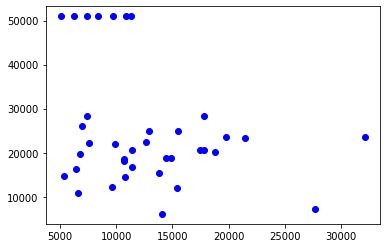

In [59]:
control_data = final_dataset[final_dataset['Parkinson']==0]
control_grip = control_data['GripAngleVariance']
controlX = control_grip.to_list()

parkinson_data = final_dataset[final_dataset['Parkinson']==1]
parkinson_grip = parkinson_data['GripAngleVariance']
parkinsonX = parkinson_grip.to_list()

plt.plot( parkinsonX[:37], controlX, 'bo')
plt.show()